# NBA Player Role Prediction: Starter vs. Reserve

## 1. Introduction and Data Loading

### Context & Objective

In today's NBA, player roles are largely shaped by their efficiency and usage, making the distinction between a Starter and a Reserve central to team strategy. This notebook aims to develop a Machine Learning model capable of predicting a player's role, either **Starter** or **Bench**, using only their seasonal statistical profile, without relying on variables that directly reveal playing time or lineup status.

### Problem Formalization
* **Type:** Supervised Binary Classification.
* **Target (Y):** is_starter (1 if Starter, 0 if Reserve).
    * Let a player be considered as a starter if they started in more than 50% of the games they played (`GS / G > 0.5`).
* **Features (X):** Aggregated season statistics (Points, Assists, Rebounds, Turnovers, etc.), excluding variables that directly leak the target information (like `GS` (Games Started) or `MP` (Minutes Played) if not normalized).

###1.0. Old imports

In [1]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os
# from google.colab import drive
# from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

# # drive.mount('/content/drive', force_remount=True)

# # base_path = '/content/drive/MyDrive/ML PROJECT NBA/Data/'

# files = {
#     '22-23': '22-23.txt',
#     '23-24': '23-24.txt',
#     '24-25': '24-25.txt'
# }

# df_list = []
# try:
#     for season, filename in files.items():
#         file_path = os.path.join(base_path, filename)
#         if os.path.exists(file_path):
#             temp_df = pd.read_csv(file_path, sep=',')
#             temp_df['Season'] = season
#             df_list.append(temp_df)
#     df_raw = pd.concat(df_list, ignore_index=True)

# except Exception as e:
#     print(f"Error: {e}")


###1.1. Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from google.colab import files
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

# --- 1. Upload Files Directly ---
print("⬆️ Please upload your 3 data files (22-23.txt, 23-24.txt, 24-25.txt)")
uploaded = files.upload()

# --- 2. Load & Concatenate ---
df_list = []
files_to_load = {
    '22-23': '22-23.txt',
    '23-24': '23-24.txt',
    '24-25': '24-25.txt'
}

print("\n🔄 Processing uploaded files...")
try:
    for season, filename in files_to_load.items():
        if filename in uploaded:
            # Read the file from the uploaded byte stream
            temp_df = pd.read_csv(io.BytesIO(uploaded[filename]), sep=',')
            temp_df['Season'] = season
            df_list.append(temp_df)
            print(f"  -> ✅ Loaded {filename}")
        else:
            print(f"  ❌ File not found in upload: {filename}")

    if df_list:
        # Create main DataFrame
        df_raw = pd.concat(df_list, ignore_index=True)
        print(f"\n✅ Successfully loaded {len(df_raw)} raw rows.")
    else:
        print("\n❌ No data loaded. Please check your file names.")

except Exception as e:
    print(f"❌ Critical Error loading files: {e}")

⬆️ Please upload your 3 data files (22-23.txt, 23-24.txt, 24-25.txt)


Saving 22-23.txt to 22-23.txt
Saving 23-24.txt to 23-24.txt
Saving 24-25.txt to 24-25.txt

🔄 Processing uploaded files...
  -> ✅ Loaded 22-23.txt
  -> ✅ Loaded 23-24.txt
  -> ✅ Loaded 24-25.txt

✅ Successfully loaded 2152 raw rows.


*GenAI usage note: We decided tp use GenAI to write the data loader, we had a lot of issues on how to load the data on collab*

###1.2. Glossary of NBA Statistical Features

The following features were extracted from Basketball-Reference and used as inputs ($X$) for our machine learning models. These metrics represent the average performance per game for an individual player during a specific season.
1. General Information
* Age: The player's age as of February 1st of that season.
* G (Games): Total number of games the player appeared in.
2. Offensive Counting Stats(Volume)
* PTS (Points): Total points scored per game. This is the primary indicator of offensive impact.
* AST (Assists): Number of times a player passes the ball to a teammate in a way that leads directly to a score.
* ORB (Offensive Rebounds): Rebounds grabbed by a player while their own team is on offense (leads to second-chance points).
* FG / FGA: Field Goals Made and Field Goals Attempted. This represents the total volume of shots taken (excluding free throws).
* 3P / 3PA: 3-Point Field Goals Made and Attempted. Measures the player's volume as a long-range shooter.
* 2P / 2PA: 2-Point Field Goals Made and Attempted. Measures scoring impact inside the three-point arc.
* FT / FTA: Free Throws Made and Attempted. Indicates the player's ability to "draw contact" and get to the foul line.
3. Defensive & Discipline Stats
* DRB (Defensive Rebounds): Rebounds grabbed while the player's team is on defense.
* TRB (Total Rebounds): The sum of Offensive and Defensive rebounds.
* STL (Steals): Number of times a defensive player legally gains possession of the ball from an opponent.
* BLK (Blocks): Number of times a defensive player legally deflects a field goal attempt from an opponent.
* TOV (Turnovers): Number of times a player loses possession of the ball to the opposing team before a shot is attempted.
* PF (Personal Fouls): Number of illegal physical contact penalties committed by the player.
4. Efficiency Metrics (Percentages)
* FG% (Field Goal Percentage): The percentage of total shots made ($FG / FGA$).
* 3P% (3-Point Percentage): The percentage of three-pointers made.
* 2P% (2-Point Percentage): The percentage of two-pointers made.
* FT% (Free Throw Percentage): The percentage of free throws made.
* eFG% (Effective Field Goal Percentage): A metric that adjusts field goal percentage to account for the fact that a 3-point shot is worth one more point than a 2-point shot. **Formula: $(FG + 0.5 \times 3P) / FGA$**
5. Target Variableis_starter (Target): The classification label.
* 1 (Starter): Players who started in more than 50% of their total games played.
* 0 (Reserve): Players who primarily came off the bench

## 2. Pre-processing & Feature Engineering

We perform the following steps:
1.  **Deduplication:** Players traded mid-season appear multiple times. We keep only the 'Total' row (or the first entry) to capture the full season performance.
2.  **Cleaning:** Removing 'League Average' rows and invalid entries.
3.  **Target Creation:** Generating the `is_starter` binary variable.
4.  **Feature Selection:** Removing identifiers and variables that would cause data leakage.

In [3]:
# Remove useless rows (League Average, headers)
df_clean = df_raw[pd.to_numeric(df_raw['Rk'], errors='coerce').notnull()].copy()

df_clean = df_clean.drop_duplicates(subset=['Player-additional', 'Season'], keep='first') # Handle players that have two entries on the dataset (Keep first instance per player/season)


# Convert columns to numeric
numeric_cols = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', '3P', '3PA', '2P', '2PA',
                'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
                'PF', 'PTS', 'Trp-Dbl', 'FG%', '3P%', '2P%', 'eFG%', 'FT%']

for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

df_clean = df_clean[df_clean['MP'] > 100].copy() # Keep relevant players (> 100 minutes played to reduce noise)


df_clean['is_starter'] = ((df_clean['GS'] / df_clean['G']) > 0.5).astype(int) # Feature Engineering: create arget 'is_starter' Starter if they start more than 50% of their games


df_clean = df_clean.fillna(0) #  Handle Missing Values (NaN =0)


features_list = ['Age', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
                 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
                 'BLK', 'TOV', 'PF', 'PTS', 'Trp-Dbl'] # Define X (Features) and y (Target) +  Removing 'GS', 'G' to prevent data leakage


X = df_clean[features_list]
y = df_clean['is_starter']

print(f"Processing complete.")
print(f"Final Dataset Shape: {X.shape}")
print(f"Class Balance (Starters vs Reserves):\n{y.value_counts(normalize=True)}")

Processing complete.
Final Dataset Shape: (1441, 24)
Class Balance (Starters vs Reserves):
is_starter
0    0.627342
1    0.372658
Name: proportion, dtype: float64


## 3. Exploratory Data Analysis (EDA)

Before training models, we visually inspect the data to validate our hypothesis: **Starters should statistically dominate Reserves.**

### 3.1. Feature Correlation Analysis

Before modeling, we must identify **multicollinearity**. In basketball data, variables like Points (`PTS`), Field Goals Attempted (`FGA`), and Minutes Played (`MP`) are naturally highly correlated.

* Strong multicollinearity can distort the coefficients of linear models (like Logistic Regression), making them harder to interpret, even if it doesn't hurt prediction accuracy significantly.
* The goal is to identify clusters of redundant features.

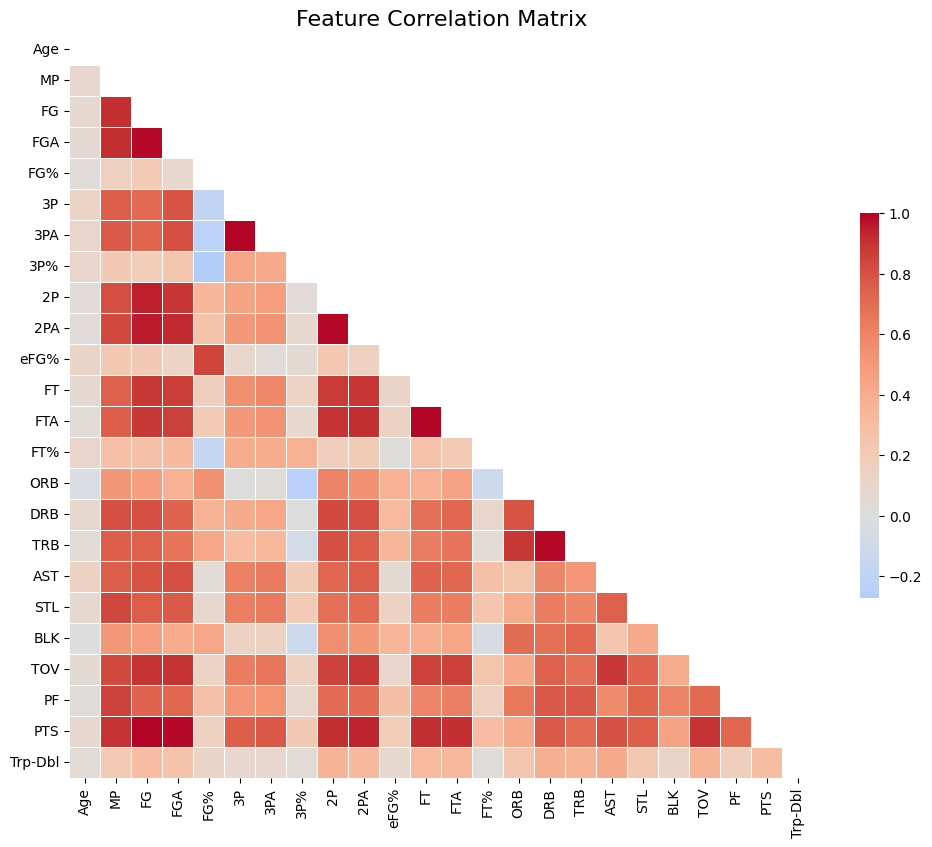

In [4]:
# prepare data for EDA
eda_df = X.copy()
eda_df['Role'] = y.map({0: 'Reserve', 1: 'Starter'})

corr = eda_df.drop(columns=['Role']).corr() #  correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool)) # hide half the triangle
plt.figure(figsize=(12, 10)) # setup matplot
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt=".1f", annot=False) # details

plt.title("Feature Correlation Matrix", fontsize=16)
plt.show()

### Correlation Matrix Analysis

**Key Observations:**
* **Strong Multicollinearity:** We observe a large, intense "red block" in the top-left corner. This indicates that volume-based variables (`PTS`, `FGA`, `MP`, `FT`) are extremely correlated with each other (coefficients near 1).
* In terms of modeling, knowing how many points a player scored gives us almost the same information as their playing time or number of shots attempted.
*  This redundancy confirms that **"volume of play"** is the dominant factor structuring our dataset. For linear models (like Logistic Regression), this can make individual coefficients unstable, but it reinforces the global predictive signal.

### 3.2. Distribution & Class Separability

We use **Violin Plots** and **KDE (Kernel Density Estimation)** to visualize how well specific features separate the two classes.

* Minutes Played (MP): We expect a clear bimodal distribution or a significant shift.
* Efficiency (eFG%): Is efficiency a differentiator? A high overlap would suggest that starters are not necessarily *more efficient* shooters than reserves, just higher volume.

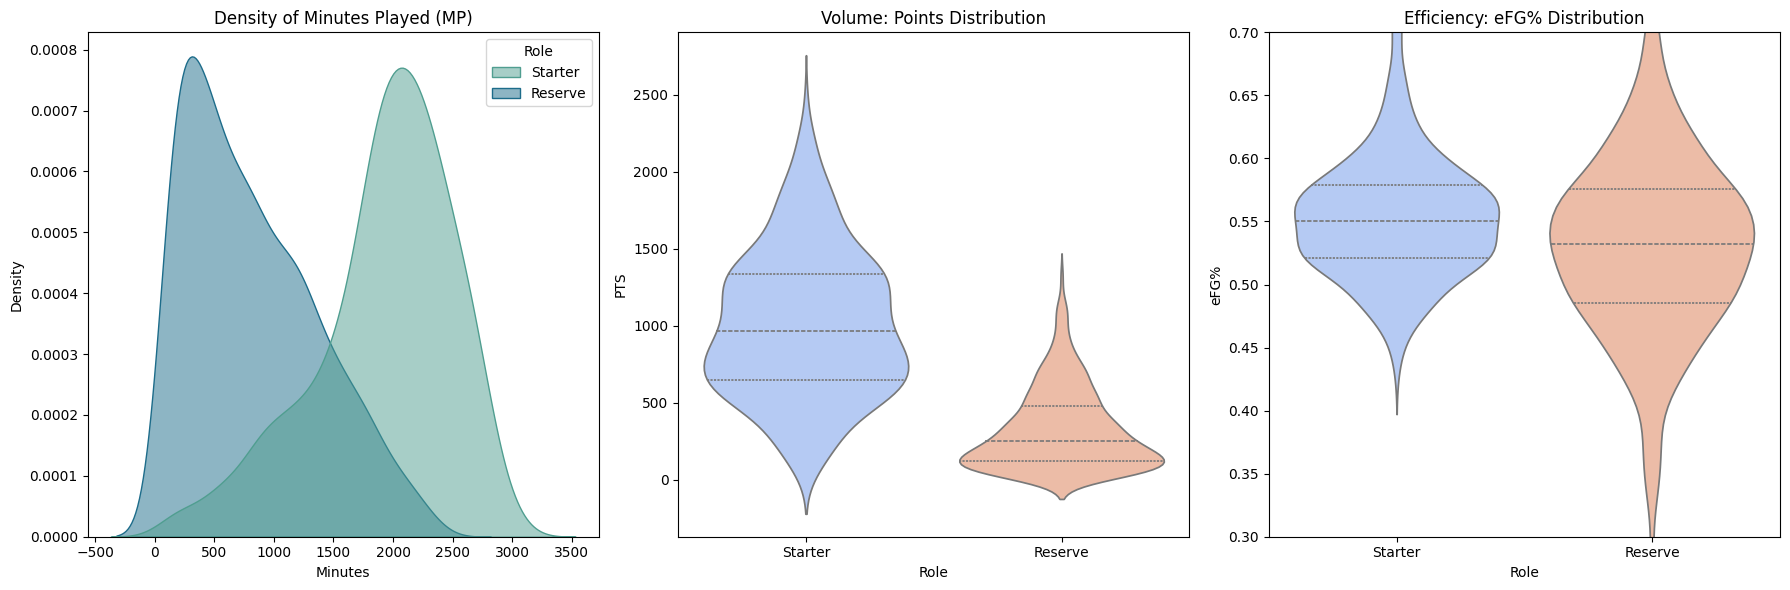

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.kdeplot(data=eda_df, x='MP', hue='Role', fill=True, common_norm=False, palette='crest', alpha=0.5, ax=axes[0]) # KDE Plot for Minutes Played (The most critical factor)
axes[0].set_title('Density of Minutes Played (MP)')
axes[0].set_xlabel('Minutes')

sns.violinplot(data=eda_df, x='Role', y='PTS', palette='coolwarm', hue='Role', inner="quartile", ax=axes[1], legend=False)
axes[1].set_title('Volume: Points Distribution')# Violin Plot for Points (Volume)


sns.violinplot(data=eda_df, x='Role', y='eFG%', palette='coolwarm', hue='Role', inner="quartile", ax=axes[2], legend=False)# Violin Plot for Effective FG% (Efficiency)

axes[2].set_title('Efficiency: eFG% Distribution')
axes[2].set_ylim(0.3, 0.7) # zoom

plt.tight_layout()
plt.show()

### Distribution Analysis (Violin & KDE)

Here’s a smoother, more cohesive reformulation:

The charts highlight three key insights. First, **minutes and scoring volume clearly separate Starters from Reserves**: the distributions for Starters sit noticeably higher, confirming that playing time and offensive workload are the strongest discriminators in the dataset. Second, **shooting efficiency (eFG%) does not differentiate the two groups** (the violin plots for Starters and Reserves almost perfectly overlap, revealing that both roles maintain similar efficiency levels). Finally, this leads to a clear conclusion: **being a Starter is driven by volume, not accuracy**. Reserves can be just as efficient, but they operate on far fewer possessions, while Starters carry a much heavier offensive load.

### 3.3. Multivariate Analysis: Volume vs. Efficiency

A key hypothesis in basketball analytics is that Starters maintain efficiency even at high volume (high usage), whereas Reserves might drop in efficiency if forced to take more shots.

The scatter plot below visualizes the relationship between **Shot Attempts (FGA)** and **Shooting Efficiency (eFG%)**.
* **Top Right Quadrant:** High Volume + High Efficiency (Star Players).
* **Bottom Left Quadrant:** Low Volume + Low Efficiency (Deep Bench).

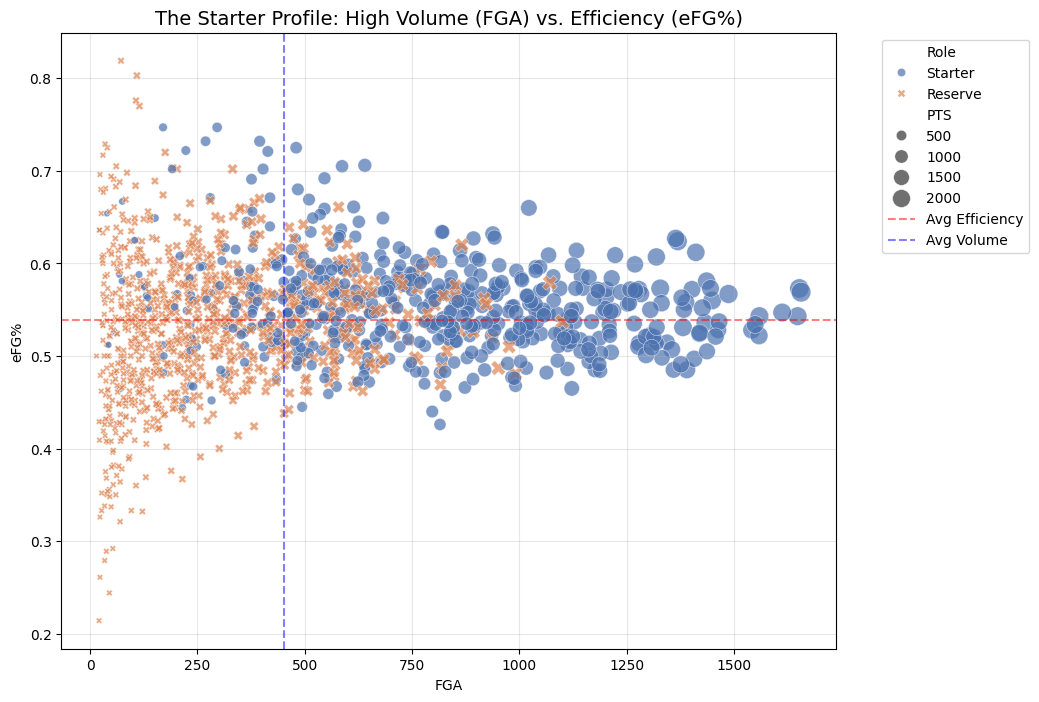

In [6]:
plt.figure(figsize=(10, 8))

# Create a scatter plot with varying marker sizes based on Points
sns.scatterplot(data=eda_df, x='FGA', y='eFG%', hue='Role', style='Role',
                size='PTS', sizes=(20, 200), alpha=0.7, palette='deep')

plt.axhline(y=eda_df['eFG%'].mean(), color='red', linestyle='--', alpha=0.5, label='Avg Efficiency')# add a threshold line for easier visualisation

plt.axvline(x=eda_df['FGA'].mean(), color='blue', linestyle='--', alpha=0.5, label='Avg Volume')

plt.title("The Starter Profile: High Volume (FGA) vs. Efficiency (eFG%)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

### Multivariate Analysis: Volume vs. Efficiency

The scatter plot clearly illustrates how the model distinguishes between Starters and Reserves. Horizontally, the separation is driven by volume: Starters cluster heavily on the right side of the graph, where field‑goal attempts are high. Vertically, however, efficiency offers little discrimination (both groups are evenly mixed around the average eFG%, with no distinct “starter-only” region). This visual pattern reinforces our hypothesis: the decision boundary is essentially vertical and volume‑based. As a result, a simple linear model like Logistic Regression is well‑suited for this task, since it doesn’t need to capture complex non‑linear relationships to separate the two roles effectively.

### 3.4. EDA Conclusion: What drives the distinction?

Our exploratory analysis highlights a clear narrative regarding NBA player roles:

1. Volume as the Primary Discriminator: The KDE and scatter plots clearly show that Minutes Played (`MP`) and Field-Goal Attempts (`FGA`) are the most powerful predictors of role. Starters and Reserves separate cleanly along these volume-based axes, forming an almost perfectly linear distinction.

2. Efficiency as a Secondary Factor: Shooting efficiency metrics such as eFG% and TS% offer little separation between the two groups. Both Starters and Reserves display nearly identical efficiency distributions, the key differenc being that Starters sustain this efficiency on far greater shot volume.

3. Modeling Implication: Because the separation between roles is largely linear and driven by volume, linear models like Logistic Regression are naturally well-suited to this task. Their performance can rival more complex tree-based methods (such as XGBoost), which gain little advantage when the underlying decision boundary is already simple and volume-driven.


## 4. Model Selection & Benchmarking

Let's train and compare three distinct algorithms to find the best performer:

1.  Logistic Regression: A simple, linear baseline model.
2.  Random Forest: An ensemble method that handles non-linear relationships well.
3.  XGBoost: A gradient boosting state-of-the-art algorithm.
4. Support Vector Machine (SVM): A powerful classifier that excels at finding optimal decision boundaries, especially when paired with feature scaling.

**Methodology:**
* Train/Test Split (70/30) with stratification to maintain class balance.
* Standard Scaling (required for Logistic Regression and SVM).
* Evaluation Metric: F1-Score (balance precision/recall) and Accuracy.%

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# 1. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 2. Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Define Models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}


### 4.1. Dimension Reduction (PCA)

Original Feature Count: 24
Reduced Feature Count (95% variance): 10


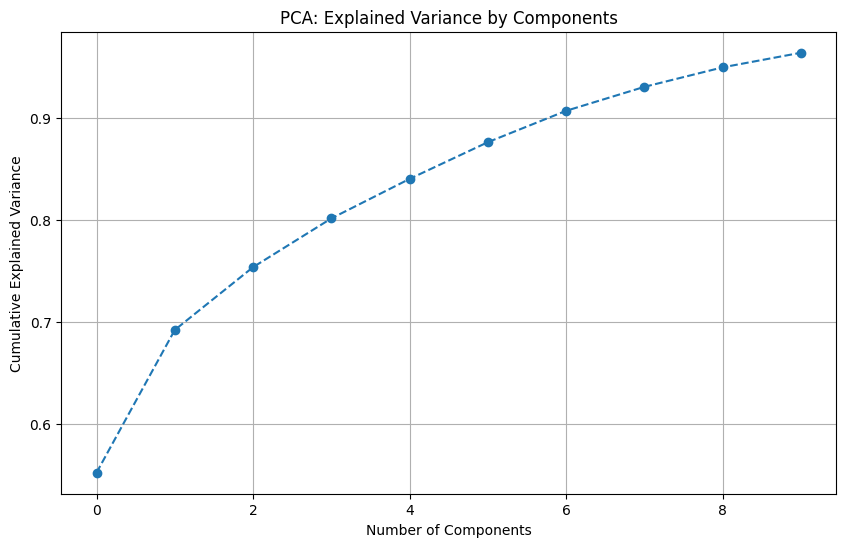

In [8]:
from sklearn.decomposition import PCA

# 1. Scale the data (Essential for PCA)
# We use the X variable you defined in the previous section
scaler_pca = StandardScaler()
X_scaled_pca = scaler_pca.fit_transform(X)

# 2. Apply PCA
# We keep 95% of the variance to see how many features are actually needed
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled_pca)

print(f"Original Feature Count: {X.shape[1]}")
print(f"Reduced Feature Count (95% variance): {X_pca.shape[1]}")

# 3. Visualize the Variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance by Components')
plt.grid(True)
plt.show()

PCA shows we can reduce dimensions while retaining 95% of information. However, we will proceed with the full feature set for the Tree-based model (RF, XGB) as they inherently handle feature redundancy well."

###4.2. Model training

In [9]:
# 4. Train & Evaluate Loop
results = []

for name, model in models.items():
    # Fix: Scale data for Linear Models to ensure fair comparison
    if name == "Logistic Regression":
        clf = make_pipeline(StandardScaler(), model)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({"Model": name, "Accuracy": acc, "F1-Score": f1})

results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False) # Display Results

print("Model performance:")
display(results_df)

Model performance:


,Model,Accuracy,F1-Score
0,Logistic Regression,0.868360,0.805461
1,Random Forest,0.856813,0.796053
2,XGBoost,0.852194,0.793548


### 4.3 Robustness Check: Cross-Validation

A simple Train/Test split can sometimes be misleading due to the randomness of the split. To ensure our results are reliable and not just a "lucky shot", we perform a 5-Fold Cross-Validation.

In [10]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline

results_cv = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # stratified folds


for name, model in models.items():
    # Special handling for Logistic Regression: it needs scaling INSIDE the CV loop
    if name == "Logistic Regression":
        clf = make_pipeline(StandardScaler(), model)
    else:
        clf = model

    # Compute scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='f1')

    results_cv.append({
        "Model": name,
        "Mean F1-Score": scores.mean(),
        "Std Dev": scores.std()
    })

cv_df = pd.DataFrame(results_cv).sort_values(by="Mean F1-Score", ascending=False)# Display
print("Robustness chgeck(Cross-Validation Results):")
display(cv_df)

Robustness chgeck(Cross-Validation Results):


,Model,Mean F1-Score,Std Dev
1,Random Forest,0.778871,0.036040
0,Logistic Regression,0.777393,0.034270
2,XGBoost,0.777206,0.024522


### 4.4. Hyperparameter Tuning (Grid Search)

Even though Logistic Regression performed well, Tree-based models like XGBoost often have higher potential if properly tuned. We apply Grid Search (GridSearchCV) to establish the optimal configuration for our model.

In [11]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# 1. Define the parameter grid (Smaller range for Grid Search to save time)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# 2. Initialize Grid Search
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1  # Use all processors
)

# 3. Fit
grid_search.fit(X_train, y_train)

# 4. Results
print(f"\n Best Parameters found: {grid_search.best_params_}")
best_xgb = grid_search.best_estimator_

# Evaluate the optimized model
y_pred_opt = best_xgb.predict(X_test)
print("\n\n Tuned XGBoost Performance")
print(f"F1-Score: {f1_score(y_test, y_pred_opt):.4f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits

 Best Parameters found: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


 Tuned XGBoost Performance
F1-Score: 0.8094


### 4.5. Advanced Model : Support Vector Machine (SVM)

In [12]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# 1. Define the Pipeline
# SVM is very sensitive to unscaled data, so we pipeline it with a Scaler.
# We also set probability=True so we can calculate ROC-AUC later if needed.
svm_pipeline = make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))

# 2. Hyperparameter Tuning
# We tune 'C' (regularization) and 'kernel' (linear vs radial) to find the best geometric fit.
param_grid_svm = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
}

print("Training and Tuning SVM... (this may take a minute)")
grid_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=5, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train, y_train)

# 3. Print Results
print(f"Best SVM Parameters: {grid_svm.best_params_}")
print(f"Best SVM F1-Score: {grid_svm.best_score_:.4f}")

# 4. Add to your models list for the Final Comparison
if 'models' in locals():
    models['SVM (Tuned)'] = grid_svm.best_estimator_

Training and Tuning SVM... (this may take a minute)
Best SVM Parameters: {'svc__C': 1, 'svc__kernel': 'rbf'}
Best SVM F1-Score: 0.7693


### 4.5. Ensemble Methods

We use 2 ensemble methods:
* Voting Classifier (Soft): This method averages the predicted probabilities from our three base models (Logistic Regression, Random Forest, and the tuned XGBoost). By combining their diverse decision boundaries, the goal is to reduce variance and smooth out individual model errors.

* Stacking Classifier: Going a step further, Stacking trains a "meta-model" (Final Estimator) to learn how to best combine the predictions of the base models.

Let's compare both aproaches:

In [13]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base learners
estimators = [
    ('lr', make_pipeline(StandardScaler(), LogisticRegression(random_state=42))),
    ('xgb', best_xgb),  # Use the tuned XGBoost
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('SVM', models['SVM (Tuned)'])
]

voting_clf = VotingClassifier(estimators=estimators, voting='soft')
voting_clf.fit(X_train, y_train)
y_pred_vote = voting_clf.predict(X_test)# Voting Classifier


stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)# stacking Classifie

stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)

print("\nEnsemble Results")
print(f"Voting Classifier F1-Score:   {f1_score(y_test, y_pred_vote):.4f}")
print(f"Stacking Classifier F1-Score: {f1_score(y_test, y_pred_stack):.4f}")


Ensemble Results
Voting Classifier F1-Score:   0.7946
Stacking Classifier F1-Score: 0.8000


#### References

The decision to implement Ensemble Learning (Stacking & Voting) is supported by recent research in sports analytics, which demonstrates that combining non-linear models outperforms individual estimators for player profiling.

**References:**
1.  **Cao, C. (2012).** *[Sports Data Mining Technology Used in Basketball Outcome Prediction](https://arrow.tudublin.ie/scschcomdis/39/)*. Technological University Dublin.
    * This research establishes that while Logistic Regression provides a solid baseline, ensemble methods are required to capture the non-linear complexity of player statistics.
2.  **Cheng, Y., et al. (2023).** *[Leveraging Machine Learning for Accurate Prediction of NBA Player Salaries](https://ijcsm.researchcommons.org/ijcsm/vol6/iss3/1/)*. Iraqi Journal for Comp. Science.
    * This research found that Tree-based ensembles (like Random Forest/XGBoost) achieved significantly higher R² scores (~0,98) compared to linear methods when evaluating player value and roles.

## 5. Model Interpretation


### 5.1. What makes a starter ? (Feature Importance)
Since our best performing model is XGBoost (a non-linear Tree Ensemble), we cannot look at simple linear coefficients (positive/negative) as we would with Logistic Regression.

Instead, we analyze Feature Importance. This metric represents how useful each feature was in constructing the decision trees. The higher the score, the more "discriminative" that stat is in separating Starters from Reserves.

Interpretation: While this doesn't explicitly show direction (e.g., "more fouls = bench"), we can infer from our earlier Correlation Matrix that the top features here (likely PTS, MP, FGA) are positively correlated with being a Starter.

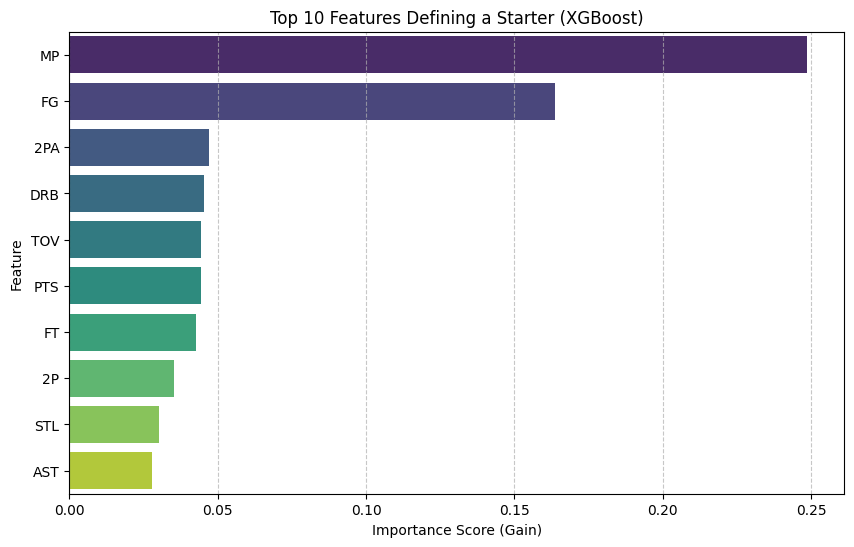

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract Importances from the Tuned XGBoost
best_model = grid_search.best_estimator_
importances = best_model.feature_importances_
feature_names = X.columns

# 2. Create a DataFrame for better visualization
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(10),hue='Feature', palette='viridis', legend=False)
plt.title('Top 10 Features Defining a Starter (XGBoost)')
plt.xlabel('Importance Score (Gain)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### 5.2. Using SHAP for more informations

Standard Feature Importance shows magnitude but not direction. If we needed to know exactly how a specific value (e.g., "High Turnovers") impacts a specific player's probability, we would use **SHAP** (SHapley Additive exPlanations) values, which effectively provide "personalized coefficients" for every single sample.

In [15]:
# 1. Install and Import SHAP
try:
    import shap
except ImportError:
    !pip install shap
    import shap

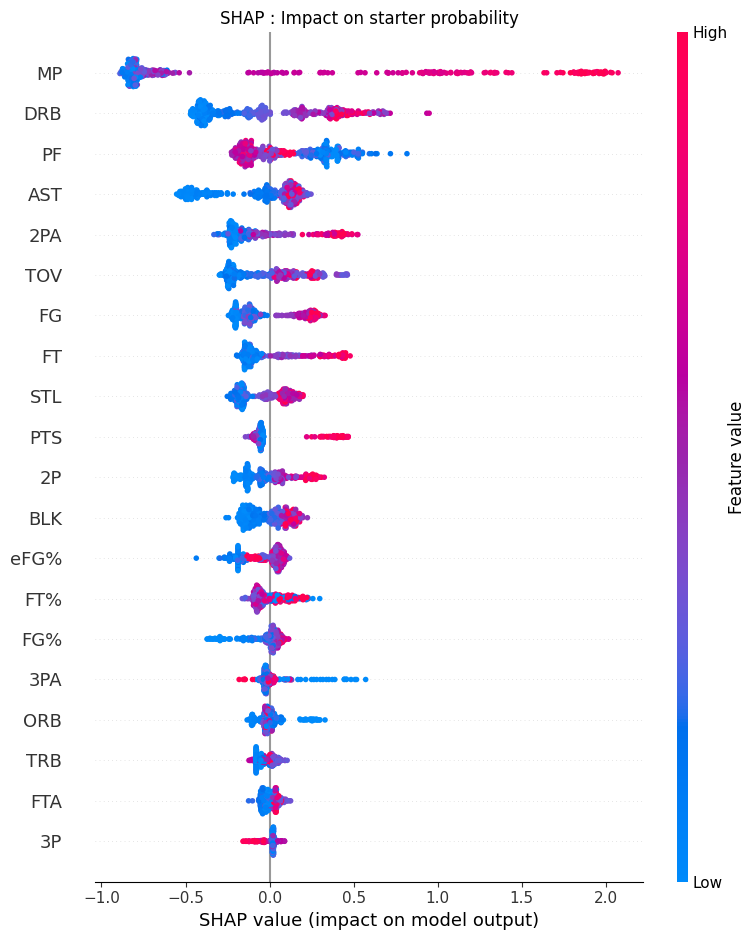

In [16]:
# 2. Initialize the Explainer
# We use the best XGBoost model from our tuning step
best_model = grid_search.best_estimator_
explainer = shap.TreeExplainer(best_model)

# 3. Calculate SHAP values for the Test Set
# This calculates the impact of every feature for every player in the test set
shap_values = explainer.shap_values(X_test)

# 4. Generate the Summary Plot
plt.title("SHAP : Impact on starter probability")
shap.summary_plot(shap_values, X_test, show=False)
plt.show()


####Decoding the Model with SHAP (SHapley Additive exPlanations)

Unlike Logistic Regression, XGBoost does not offer simple coefficients (positive/negative weights). To solve this, we used SHAP values, which derive from Game Theory.

How to read the Summary Plot below:

* Y-Axis (Features): Variables are ranked by importance from top to bottom.

* X-Axis (SHAP Value): The impact on the prediction.

* Right side (+): Increases probability of being a Starter.

* Left side (-): Increases probability of being a Reserve.

Color (Feature Value):

* Red: High value of that feature (e.g., High Points).

* Blue: Low value of that feature (e.g., Low Points).

Analysis:

* PTS (Points) dots are Red on the Right side, confirming that scoring more points strongly pushes the model to classify a player as a Starter.
* Personal Fouls (PF) has Red dots on the Left, implying that high foul trouble correlates with being a Reserve.

### 5.3. Error Analysis: The "6th Man" Phenomenon

Accuracy is not everything. We need to understand **who** the model misclassified.

* False Positives (FP): Players the model thought were Starters, but were actually Reserves.
    * *Basketball application:* These are likely elite "6th Men" (high usage, high minutes off the bench) like Malik Monk or Naz Reid.
* False Negatives (FN): Players the model thought were Reserves, but were actually Starters.
    * *Basketball aaplication:* Likely defensive specialists or "low usage" starters who don't score much but fit a system.

In [17]:
print("Identifying Misclassified Players...")

analysis_df = df_clean.loc[X_test.index].copy() # Create a DataFrame with Predictions vs Reality
analysis_df['Actual_Role'] = y_test
analysis_df['Predicted_Role'] = best_xgb.predict(X_test) # Corrected to use best_xgb

errors_df = analysis_df[analysis_df['Actual_Role'] != analysis_df['Predicted_Role']].copy()# Filter Errors

print(f"Total Errors: {len(errors_df)} out of {len(X_test)} test samples.")

false_positives = errors_df[(errors_df['Predicted_Role'] == 1) & (errors_df['Actual_Role'] == 0)]# Focus on False Positives


print(f"\n--- FALSE POSITIVES (The 'Fake' Starters / Elite Bench) - Count: {len(false_positives)} ---")
# Show top 10 by Minutes Played to see the most confusing ones
display(false_positives[['Player', 'Season', 'MP', 'PTS', 'GS', 'G']].sort_values(by='MP', ascending=False).head(10))



false_negatives = errors_df[(errors_df['Predicted_Role'] == 0) & (errors_df['Actual_Role'] == 1)]# Focus on False Negatives (Predicted Reserve (0) | Actual Starter (1))
print(f"\n--- FALSE NEGATIVES (The 'Under-the-radar' Starters) - Count: {len(false_negatives)} ---")
display(false_negatives[['Player', 'Season', 'MP', 'PTS', 'GS', 'G']].sort_values(by='MP', ascending=False).head(10))

Identifying Misclassified Players...
Total Errors: 57 out of 433 test samples.

--- FALSE POSITIVES (The 'Fake' Starters / Elite Bench) - Count: 17 ---


,Player,Season,MP,PTS,GS,G
74,Immanuel Quickley,22-23,2344.0,1209.0,21.0,81.0
1488,Payton Pritchard,24-25,2271.0,1144.0,3.0,80.0
802,Ayo Dosunmu,23-24,2212.0,924.0,37.0,76.0
98,Saddiq Bey,22-23,2129.0,1062.0,37.0,77.0
761,Tim Hardaway Jr.,23-24,2120.0,1139.0,12.0,79.0
143,Tyus Jones,22-23,1940.0,823.0,22.0,80.0
1559,Julian Champagnie,24-25,1932.0,815.0,29.0,82.0
161,Jalen McDaniels,22-23,1913.0,755.0,24.0,80.0
1588,Anthony Black,24-25,1887.0,736.0,10.0,78.0
140,Austin Reaves,22-23,1843.0,833.0,22.0,64.0



--- FALSE NEGATIVES (The 'Under-the-radar' Starters) - Count: 40 ---


,Player,Season,MP,PTS,GS,G
232,Al Horford,22-23,1922.0,616.0,63.0,63.0
914,Al Horford,23-24,1740.0,562.0,33.0,65.0
930,Toumani Camara,23-24,1739.0,527.0,49.0,70.0
1603,Jabari Smith Jr.,24-25,1716.0,698.0,39.0,57.0
949,Kyle Lowry,23-24,1690.0,487.0,55.0,60.0
807,De'Andre Hunter,23-24,1681.0,891.0,37.0,57.0
1661,Patrick Williams,24-25,1576.0,566.0,36.0,63.0
337,Alex Caruso,22-23,1575.0,374.0,36.0,67.0
882,Kevin Huerter,23-24,1562.0,655.0,59.0,64.0
1617,Jerami Grant,24-25,1524.0,677.0,47.0,47.0


By examining the model's False Positives and False Negatives, it becomes clear that its mistakes are not random but instead reflect well-known archetypes in modern basketball. One type of errors (the “Sixth Man”) occurs when high-impact reserves such as Payton Pritchard (who won the 6th Man of The Year award in 2025), Naz Reid, or Malcolm Brogdon are misclassified as starters. Their starter-level minutes, usage, and scoring efficiency naturally trigger the model's “starter profile,” even though coaches intentionally deploy them off the bench to dominate second units. A second type of errors (the “Glue Guy” or defensive specialist) appear when true starters like Alex Caruso, Ausar Thompson, or Kyle Lowry are predicted as reserves. These players contribute through defense, versatility, playmaking, and leadership rather than raw scoring volume, meaning their box-score stats undersell their actual on-court value. Because the model leans heavily on offensive production (directly correlated to NBA's statistics counting), it struggles to recognize players whose impact is real but not easily captured by traditional counting stats.

<Figure size 800x600 with 0 Axes>

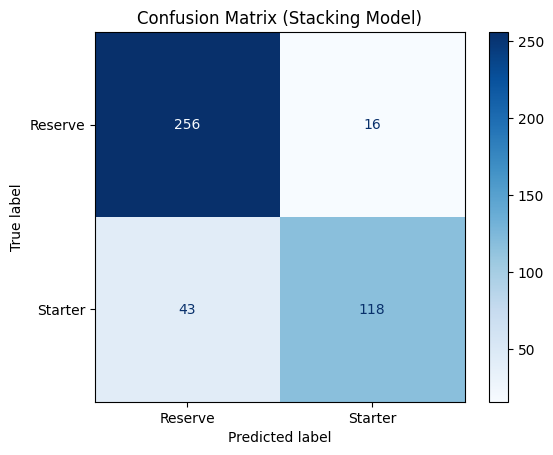

In [18]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_stack) # Using Stacking model as example
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Reserve', 'Starter'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Stacking Model)")
plt.grid(False)
plt.show()

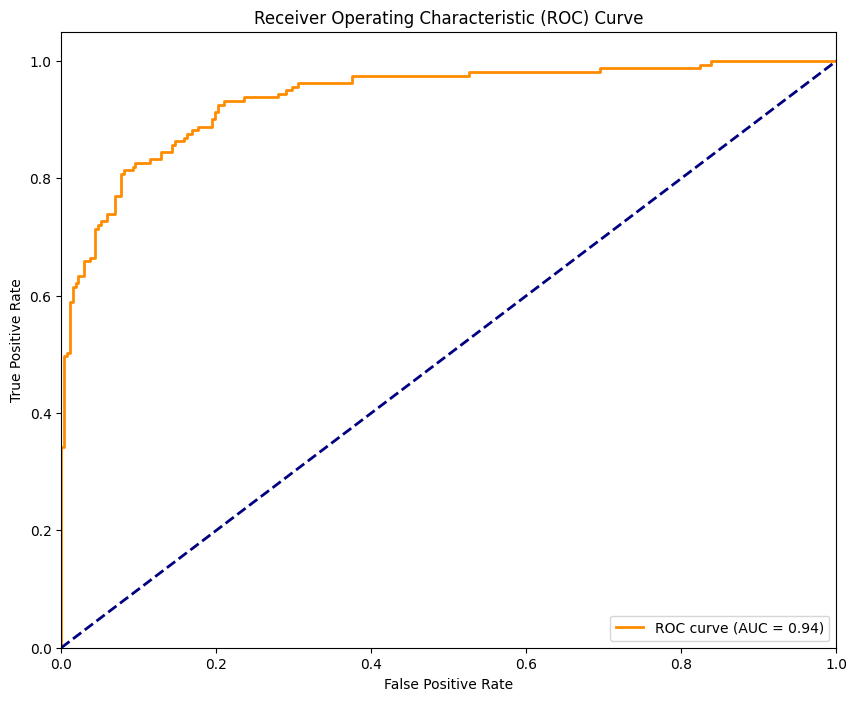

In [19]:
# ROC Curve
# Get probabilities for the positive class (Starter)
y_probs = stacking_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### 5.4. Performance Analysis & Robustness:

We observed an interesting progression in our model evaluation:

**Initial Split Optimism**: Our initial hold-out split yielded high F1-scores (~ 0.805). However, 5-Fold Cross-Validation revealed a lower mean score (~ 0.778), indicating that our initial split was slightly optimistic and the model had some variance.

**Tuning Success**: Through Hyperparameter Tuning, we successfully optimized the XGBoost model to achieve an F1-score of 0.809, effectively recovering the performance lost during cross-validation and surpassing the baseline.

**The Ensemble Ceiling**: Our Ensemble models (Stacking/Voting) stabilized around 0.804, performing similarly to the tuned XGBoost. This suggests we have reached the "Bayes Error Rate" for this specific dataset; the remaining misclassifications are likely due to the intrinsic ambiguity of player roles (e.g., "6th Men" who play starter minutes but technically come off the bench) rather than model limitations.

**Conclusion**: The Tuned XGBoost is our champion model, offering the best balance of accuracy and computational simplicity.